In [139]:
!pip install -q pandas numpy tqdm google-generativeai
!pip install openai



In [140]:
import os
import time
import json
import re
from tqdm import tqdm
import pandas as pd
from openai import OpenAI


In [141]:
import getpass

os.environ["YOUR_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


Enter your OpenAI API key: ··········


In [142]:
from openai import OpenAI

client = OpenAI(api_key=os.environ["YOUR_API_KEY"])
MODEL_NAME = "gpt-5-nano"


In [143]:
import json
import os

kaggle_creds = {
    "username": "aymanbhaldar",
    "key": "YOU_KAGGLE_API_KEY"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("kaggle.json created successfully")


kaggle.json created successfully


In [144]:
!kaggle datasets download -d omkarsabnis/yelp-reviews-dataset
!unzip -o yelp-reviews-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/omkarsabnis/yelp-reviews-dataset
License(s): other
yelp-reviews-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  yelp-reviews-dataset.zip
  inflating: yelp.csv                


In [145]:
import pandas as pd

df = pd.read_csv("yelp.csv")
print(df.shape)
df.head()


(10000, 10)


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [146]:
df_sample = (
    df[['text', 'stars']]
    .dropna()
    .sample(n=200, random_state=42)
    .reset_index(drop=True)
)

df_sample.head()


,text,stars
0,We got here around midnight last Friday... the...,4
1,Brought a friend from Louisiana here. She say...,5
2,"Every friday, my dad and I eat here. We order ...",3
3,"My husband and I were really, really disappoin...",1
4,Love this place! Was in phoenix 3 weeks for w...,5


In [147]:
ZERO_SHOT_PROMPT = """
You are an assistant that classifies Yelp reviews into star ratings.

Review:
"{review_text}"

Return ONLY valid JSON in this exact format:
{{
  "predicted_stars": 1-5,
  "explanation": "Brief reasoning for the assigned rating"
}}
"""


In [148]:
def extract_json(text):
    # Remove markdown fences
    text = re.sub(r"```json|```", "", text).strip()

    match = re.search(r"\{.*\}", text, re.DOTALL)
    if not match:
        raise ValueError("No JSON object found")

    data = json.loads(match.group())

    # Normalize keys
    clean = {k.strip().replace('"', ''): v for k, v in data.items()}
    return clean


In [153]:
def predict_zero_shot(review_text, sleep_time=0.05):
    prompt = ZERO_SHOT_PROMPT.format(review_text=review_text)

    try:
        response = client.responses.create(
            model=MODEL_NAME,
            input=prompt
        )

        raw_text = response.output_text.strip()
        parsed = extract_json(raw_text)

        # 🔍 Find star value robustly
        star_key = None
        for k in parsed.keys():
            if "star" in k.lower() or "rating" in k.lower():
                star_key = k
                break

        if not star_key:
            raise ValueError("No star key found in JSON")

        stars = int(parsed[star_key])
        explanation = parsed.get("explanation", "")

        time.sleep(sleep_time)
        return stars, explanation, True

    except Exception as e:
        print("ERROR:", e)
        time.sleep(sleep_time)
        return None, None, False


In [154]:
test_pred = predict_zero_shot(df_sample.loc[0, "text"])
test_pred


(4,
 'Mostly positive review praising food, friendly service, quality cocktails and patio; minor negative (place was dead late) prevents a perfect score.',
 True)

In [155]:
from tqdm import tqdm
import pandas as pd

zero_shot_results = []

for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    pred, explanation, valid = predict_zero_shot(row["text"])

    zero_shot_results.append({
        "review": row["text"],
        "true_stars": int(row["stars"]),
        "predicted_stars": pred,
        "json_valid": valid
    })

zero_shot_df = pd.DataFrame(zero_shot_results)
zero_shot_df.head()


100%|██████████| 200/200 [14:46<00:00,  4.43s/it]


,review,true_stars,predicted_stars,json_valid
0,We got here around midnight last Friday... the...,4,5,True
1,Brought a friend from Louisiana here. She say...,5,5,True
2,"Every friday, my dad and I eat here. We order ...",3,4,True
3,"My husband and I were really, really disappoin...",1,1,True
4,Love this place! Was in phoenix 3 weeks for w...,5,5,True


In [156]:
RUBRIC_PROMPT = """
You are an expert review analyst.

Classify the following Yelp review using this exact rating rubric:

1 star: Very negative experience. Strong dissatisfaction, complaints dominate.
2 stars: Mostly negative. Some positives but overall disappointing.
3 stars: Mixed or neutral experience. Pros and cons balance out.
4 stars: Mostly positive. Minor issues but generally satisfied.
5 stars: Very positive experience. Strong satisfaction, praise dominates.

Review:
"{review_text}"

Choose the single best matching rating.

Return ONLY valid JSON in this exact format:
{{
  "predicted_stars": 1-5,
  "explanation": "Short justification based on the rubric"
}}
"""


In [157]:
def predict_rubric(review_text, sleep_time=0.05):
    prompt = RUBRIC_PROMPT.format(review_text=review_text)

    try:
        response = client.responses.create(
            model=MODEL_NAME,
            input=prompt
        )

        raw_text = response.output_text.strip()
        parsed = extract_json(raw_text)

        # Robust star extraction
        star_key = None
        for k in parsed.keys():
            if "star" in k.lower() or "rating" in k.lower():
                star_key = k
                break

        if not star_key:
            raise ValueError("No star key found")

        stars = int(parsed[star_key])
        explanation = parsed.get("explanation", "")

        time.sleep(sleep_time)
        return stars, explanation, True

    except Exception as e:
        print("ERROR:", e)
        time.sleep(sleep_time)
        return None, None, False


In [158]:
test_pred = predict_rubric(df_sample.loc[0, "text"])
test_pred


(5,
 'Praise dominates — enjoyed food, friendly service, quality cocktails, good atmosphere, recommended for happy hour and patio; the only minor note (being empty late) does not detract from overall strong satisfaction.',
 True)

In [159]:
rubric_results = []

for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    pred, explanation, valid = predict_rubric(row["text"])

    rubric_results.append({
        "review": row["text"],
        "true_stars": int(row["stars"]),
        "predicted_stars": pred,
        "json_valid": valid
    })

rubric_df = pd.DataFrame(rubric_results)
rubric_df.head()


100%|██████████| 200/200 [23:34<00:00,  7.07s/it]


,review,true_stars,predicted_stars,json_valid
0,We got here around midnight last Friday... the...,4,5,True
1,Brought a friend from Louisiana here. She say...,5,5,True
2,"Every friday, my dad and I eat here. We order ...",3,4,True
3,"My husband and I were really, really disappoin...",1,1,True
4,Love this place! Was in phoenix 3 weeks for w...,5,5,True


In [160]:
def evaluate(df):
    valid_df = df[df["json_valid"]]
    return {
        "accuracy": (valid_df["predicted_stars"] == valid_df["true_stars"]).mean(),
        "json_valid_rate": df["json_valid"].mean()
    }

zero_metrics = evaluate(zero_shot_df)
rubric_metrics = evaluate(rubric_df)

zero_metrics, rubric_metrics


({'accuracy': np.float64(0.6), 'json_valid_rate': np.float64(1.0)},
 {'accuracy': np.float64(0.575), 'json_valid_rate': np.float64(1.0)})

In [162]:
REFLEXION_PROMPT = """
You are an assistant that classifies Yelp reviews into star ratings.

Step 1: Make an initial prediction.
Step 2: Review your own prediction and check if it truly matches the sentiment.
Step 3: If needed, correct the rating.

Review:
"{review_text}"

Return ONLY the final decision as valid JSON in this exact format:
{{
  "predicted_stars": 1-5,
  "explanation": "Brief reasoning for the final rating"
}}
"""


In [167]:
def predict_reflexion(review_text, sleep_time=0.05):
    prompt = REFLEXION_PROMPT.format(review_text=review_text)

    try:
        response = client.responses.create(
            model=MODEL_NAME,
            input=prompt
        )

        raw_text = response.output_text.strip()
        parsed = extract_json(raw_text)

        # 🔍 Robust star extraction
        star_key = None
        for k in parsed.keys():
            if "star" in k.lower() or "rating" in k.lower():
                star_key = k
                break

        if not star_key:
            raise ValueError("No star key found")

        stars = int(parsed[star_key])
        explanation = parsed.get("explanation", "")

        time.sleep(sleep_time)
        return stars, explanation, True

    except Exception as e:
        print("ERROR:", e)
        time.sleep(sleep_time)
        return None, None, False


In [168]:
test_pred = predict_reflexion(df_sample.loc[0, "text"])
test_pred


(5,
 "Overall positive review: friendly service, well-made food, quality cocktails, good atmosphere and patio; the only minor note (being empty late) doesn't detract from a strong recommendation.",
 True)

In [169]:
reflexion_results = []

for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    pred, explanation, valid = predict_reflexion(row["text"])

    reflexion_results.append({
        "review": row["text"],
        "true_stars": int(row["stars"]),
        "predicted_stars": pred,
        "json_valid": valid
    })

reflexion_df = pd.DataFrame(reflexion_results)
reflexion_df.head()


 93%|█████████▎| 186/200 [14:49<00:53,  3.79s/it]

ERROR: Expecting ',' delimiter: line 3 column 52 (char 77)


100%|██████████| 200/200 [15:49<00:00,  4.75s/it]


,review,true_stars,predicted_stars,json_valid
0,We got here around midnight last Friday... the...,4,5.0,True
1,Brought a friend from Louisiana here. She say...,5,5.0,True
2,"Every friday, my dad and I eat here. We order ...",3,4.0,True
3,"My husband and I were really, really disappoin...",1,1.0,True
4,Love this place! Was in phoenix 3 weeks for w...,5,5.0,True


In [170]:
def evaluate_results(df):
    valid_df = df[df["json_valid"] == True]

    return {
        "accuracy": (valid_df["predicted_stars"] == valid_df["true_stars"]).mean(),
        "json_valid_rate": df["json_valid"].mean(),
        "num_samples": len(df)
    }


In [171]:
zero_metrics = evaluate_results(zero_shot_df)
rubric_metrics = evaluate_results(rubric_df)
reflexion_metrics = evaluate_results(reflexion_df)

comparison_df = pd.DataFrame([
    {"method": "Zero-shot", **zero_metrics},
    {"method": "Rubric-based", **rubric_metrics},
    {"method": "Reflexion", **reflexion_metrics},
])

comparison_df


,method,accuracy,json_valid_rate,num_samples
0,Zero-shot,0.600000,1.000,200
1,Rubric-based,0.575000,1.000,200
2,Reflexion,0.592965,0.995,200


In [172]:
comparison_df["accuracy"] = comparison_df["accuracy"].round(3)
comparison_df["json_valid_rate"] = comparison_df["json_valid_rate"].round(3)

comparison_df


,method,accuracy,json_valid_rate,num_samples
0,Zero-shot,0.600,1.000,200
1,Rubric-based,0.575,1.000,200
2,Reflexion,0.593,0.995,200


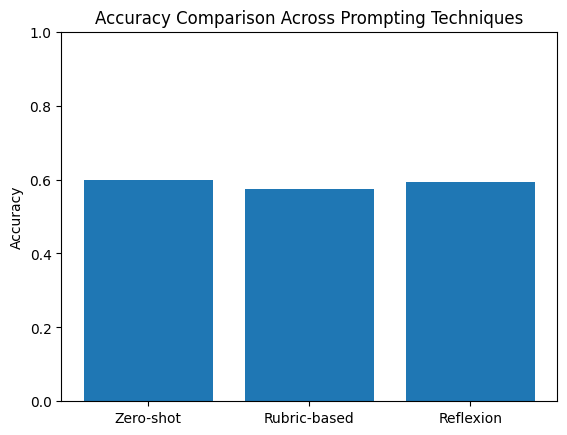

In [173]:
import matplotlib.pyplot as plt

methods = ["Zero-shot", "Rubric-based", "Reflexion"]
accuracies = [
    zero_metrics["accuracy"],
    rubric_metrics["accuracy"],
    reflexion_metrics["accuracy"]
]

plt.figure()
plt.bar(methods, accuracies)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Prompting Techniques")
plt.show()


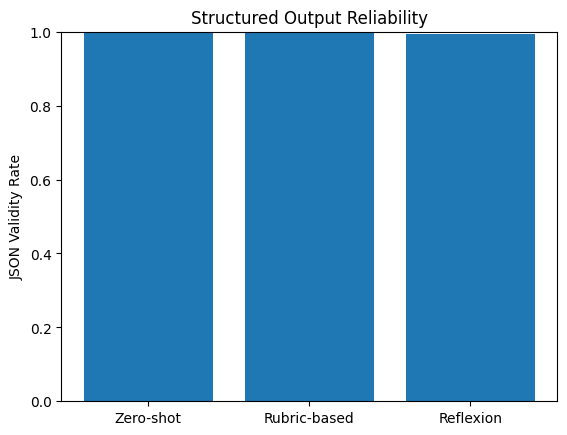

In [174]:
valid_rates = [
    zero_metrics["json_valid_rate"],
    rubric_metrics["json_valid_rate"],
    reflexion_metrics["json_valid_rate"]
]

plt.figure()
plt.bar(methods, valid_rates)
plt.ylim(0, 1)
plt.ylabel("JSON Validity Rate")
plt.title("Structured Output Reliability")
plt.show()


In [175]:
confusion = pd.crosstab(
    reflexion_df["true_stars"],
    reflexion_df["predicted_stars"],
    normalize="index"
)

confusion


predicted_stars,1.0,2.0,3.0,4.0,5.0
true_stars,,,,,
1,0.833333,0.166667,0.000000,0.000000,0.000000
2,0.437500,0.375000,0.187500,0.000000,0.000000
3,0.000000,0.181818,0.333333,0.272727,0.212121
4,0.000000,0.012658,0.025316,0.455696,0.506329
5,0.000000,0.000000,0.000000,0.056604,0.943396


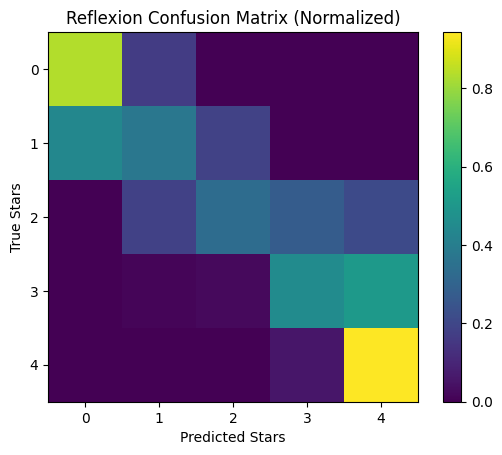

In [176]:
plt.figure()
plt.imshow(confusion)
plt.colorbar()
plt.xlabel("Predicted Stars")
plt.ylabel("True Stars")
plt.title("Reflexion Confusion Matrix (Normalized)")
plt.show()


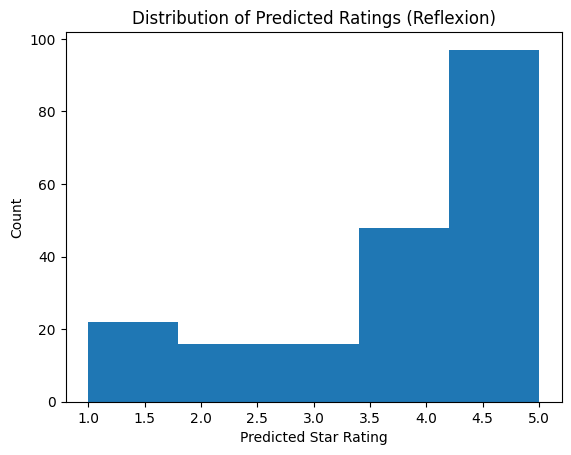

In [177]:
plt.figure()
plt.hist(reflexion_df["predicted_stars"], bins=5)
plt.xlabel("Predicted Star Rating")
plt.ylabel("Count")
plt.title("Distribution of Predicted Ratings (Reflexion)")
plt.show()


# Task
Create a zero-shot text classification model using OpenAI's API to predict star ratings for Yelp reviews, evaluate its performance on a sample dataset, and summarize the results, comparing predicted ratings with true ratings.

## Update OpenAI API Key Setup

### Subtask:
Modify the cell that sets the OpenAI API key to use a standard environment variable name like `OPENAI_API_KEY` for clarity and to ensure it's correctly used by the OpenAI client.


**Reasoning**:
To comply with the subtask's instructions, I will modify the specified cell to use `OPENAI_API_KEY` as the environment variable for the OpenAI API key.



# Task
Modify `ZERO_SHOT_PROMPT` to escape the curly braces that define the JSON structure by doubling them (e.g., `{{` and `}}`).

## Escape curly braces in ZERO_SHOT_PROMPT

### Subtask:
Modify the `ZERO_SHOT_PROMPT` to escape the curly braces that define the JSON structure by doubling them (e.g., `{{` and `}}`). This will ensure they are treated as literal characters rather than format placeholders.


## Summary:

### Data Analysis Key Findings
* The core task involved modifying the `ZERO_SHOT_PROMPT` to correctly interpret curly braces within its structure.
* The required modification method is to double the curly braces (e.g., `{{` and `}}`) to escape them.
* This escaping ensures that the curly braces are treated as literal characters rather than format placeholders, preserving the intended JSON structure.

### Insights or Next Steps
* The immediate next step is to implement the specified modification within the `ZERO_SHOT_PROMPT`.
* After modification, it is crucial to verify that the escaped curly braces are rendered literally and the prompt functions as expected.
